<h3>Analisis algoritma Machine Learning menggunakan Suport Vektor Machine, Naive Bayes, dan Random Forest untuk menemukan akurasi tinggi dalam penerimaa Vaksin H1N1 kasus Influenza</h3>
<p>Dalam kasus ini penulis memiliki batasan dalam melakukan kasusnya, yang hanya berfokus pada prediksi vaksin H1N1 bukan vaksin flu musiaman atau (seasonal_vaksin)</p>
<p>Tujuanya adalah untuk memberikan analisa mana model machine learning yang terbaik dalam akurasi penerimaan vaksin</p>

In [40]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score

)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix




<h2>Data Understanding</h2>

In [3]:
data = pd.read_csv('data/H1N1_Flu_Vaccines.csv')
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [4]:
#cek dimensi data dan tipe data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

<Axes: >

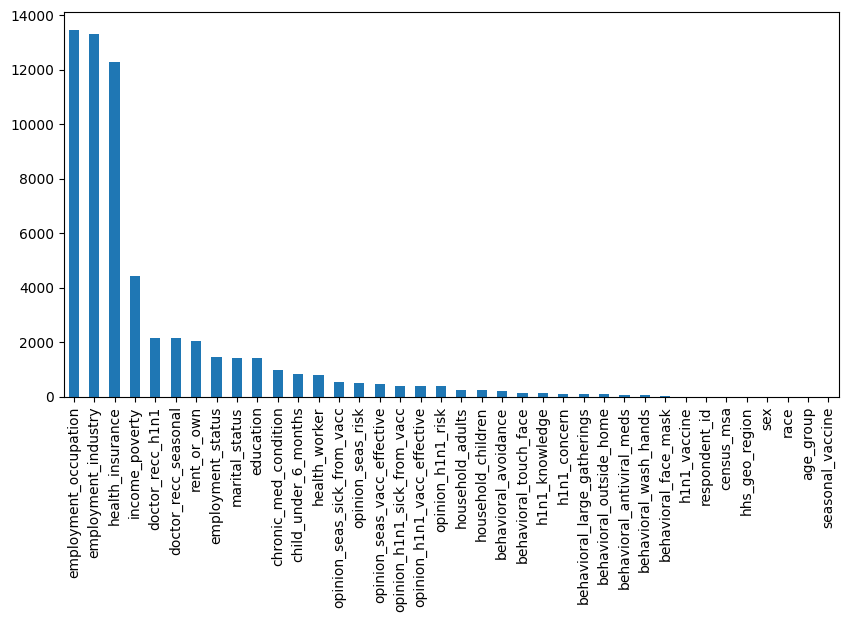

In [5]:
data.isna().sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

<p>grafik diatas menampilkan kolom yang memiliki missing value</p>

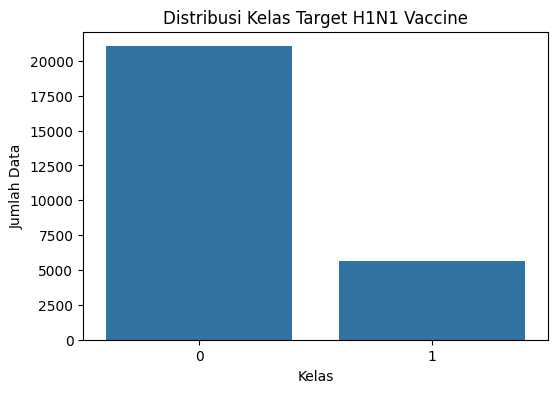

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='h1n1_vaccine', data=data)
plt.title('Distribusi Kelas Target H1N1 Vaccine')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.show()


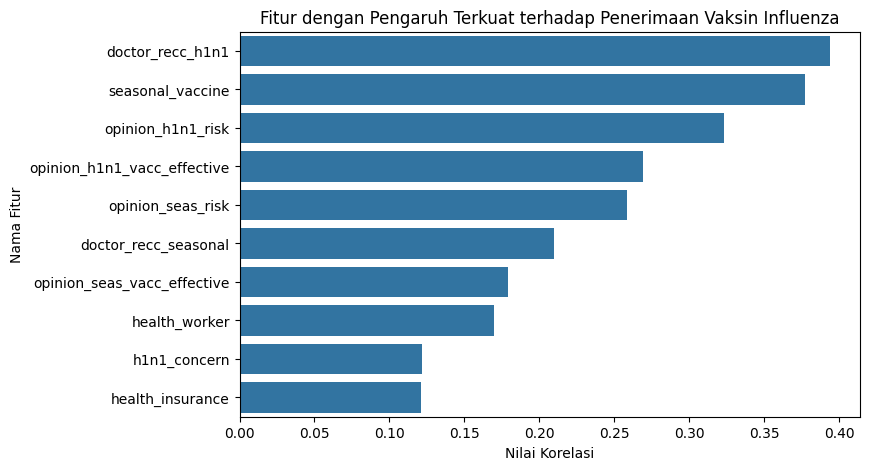

In [7]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])
corr_target = numerical_data.corr()['h1n1_vaccine']

# Urutkan dari yang paling kuat
corr_sorted = corr_target.sort_values(key=abs, ascending=False)
corr_sorted = corr_sorted.drop('h1n1_vaccine')
top_features = corr_sorted.head(10)
top_features

plt.figure(figsize=(8,5))
sns.barplot(
    x=top_features.values,
    y=top_features.index
)
plt.title('Fitur dengan Pengaruh Terkuat terhadap Penerimaan Vaksin Influenza')
plt.xlabel('Nilai Korelasi')
plt.ylabel('Nama Fitur')
plt.show()

<h1>Preprocessing</h1>

In [8]:
# data.drop(columns=['respondent_id','doctor_recc_seasonal','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','race','sex','income_poverty','hhs_geo_region','census_msa','employment_industry','employment_occupation','seasonal_vaccine'], inplace=True)

data.drop(columns=['respondent_id','race','sex','income_poverty','hhs_geo_region','census_msa','employment_industry','employment_occupation','health_insurance'], inplace=True)

In [9]:
for col in data.columns:
    if data[col].isna().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_24788\236084314.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


kolom yang tidak berpengaruh dalam hasil prediksi vaksin influenza dihilangkan


In [10]:
data.isnull().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
marital_status                 0
rent_or_own                    0
employment_status              0
household_adults               0
household_children             0
h1n1_vaccine                   0
seasonal_vaccine               0
dtype: int64

mengisi nilai missing value dengan nilai modus, karena untuk data kategorikal dan numerikal akan lebih aman disi dengan nilai modus untuk menghindari data bias

In [11]:
#melakukan one hot encoding pada data kategorikal
categorical=data.select_dtypes(object).columns
data=pd.get_dummies(data,columns=categorical)

#mengubah tipe data boolean menjadi integer
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)


Fitur kategorikal yang bertipe object dikonversi menjadi bentuk numerik menggunakan teknik one-hot encoding agar dapat diproses oleh algoritma machine learning.

In [12]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [13]:
data.shape

(26707, 40)

In [14]:
data.columns = (
    data.columns
      .str.lower()
      .str.strip()
      .str.replace(' ', '_')
)

In [ ]:
# # Feature & target
# x = data.drop("h1n1_vaccine", axis=1)
# y = data["h1n1_vaccine"]

# # Best models (hasil tuning)
# best_models = {
#     "SVM": SVC(
#         kernel='rbf',
#         C=10,
#         gamma=0.1,
#         probability=True,
#         random_state=42
#     ),
#     "Naive Bayes": GaussianNB(
#         var_smoothing=1e-09
#     ),
#     "Random Forest": RandomForestClassifier(
#         n_estimators=150,
#         max_depth=None,
#         min_samples_split=5,
#         min_samples_leaf=1,
#         max_features='sqrt',
#         random_state=42
#     )
# }

# # Skenario test size
# test_sizes = [0.1, 0.2, 0.3]

# evaluation_results = []

# for ts in test_sizes:
#     # Train-test split
#     x_train, x_test, y_train, y_test = train_test_split(
#         x, y,
#         test_size=ts,
#         random_state=42,
#         stratify=y
#     )

#     # SMOTE hanya pada data training
#     smote = SMOTE(random_state=42)
#     x_smote, y_smote = smote.fit_resample(x_train, y_train)

#     # Loop tiap algoritma
#     for name, model in best_models.items():
#         # Training
#         model.fit(x_smote, y_smote)

#         # Testing
#         y_pred = model.predict(x_test)
#         y_prob = model.predict_proba(x_test)[:, 1]

#         evaluation_results.append({
#             'Test Size (%)': int(ts * 100),
#             'Model': name,
#             'Accuracy': accuracy_score(y_test, y_pred),
#             'Precision': precision_score(y_test, y_pred),
#             'Recall': recall_score(y_test, y_pred),
#             'F1-Score': f1_score(y_test, y_pred),
#             'ROC AUC': roc_auc_score(y_test, y_prob)
#         })

# # Hasil akhir
# df_eval = pd.DataFrame(evaluation_results)
# df_eval

,Test Size (%),Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,10,SVM,0.824036,0.592030,0.550265,0.570384,0.814552
1,10,Naive Bayes,0.704231,0.395305,0.742504,0.515931,0.785617
2,10,Random Forest,0.850992,0.692483,0.536155,0.604374,0.866986
3,20,SVM,0.824598,0.596869,0.537445,0.565600,0.807924
4,20,Naive Bayes,0.702171,0.390490,0.716300,0.505440,0.771571
5,20,Random Forest,0.849682,0.684855,0.541850,0.605017,0.862279
6,30,SVM,0.826781,0.602081,0.544066,0.571605,0.813855
7,30,Naive Bayes,0.699988,0.388713,0.720329,0.504942,0.772028
8,30,Random Forest,0.849619,0.679422,0.552879,0.609653,0.865068


In [35]:
x = data.drop("h1n1_vaccine", axis=1)
y = data["h1n1_vaccine"]

def split_and_smote(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, stratify=y)
    x_smote, y_smote=SMOTE().fit_resample(x_train, y_train)
    return x_smote, y_smote, x_test, y_test

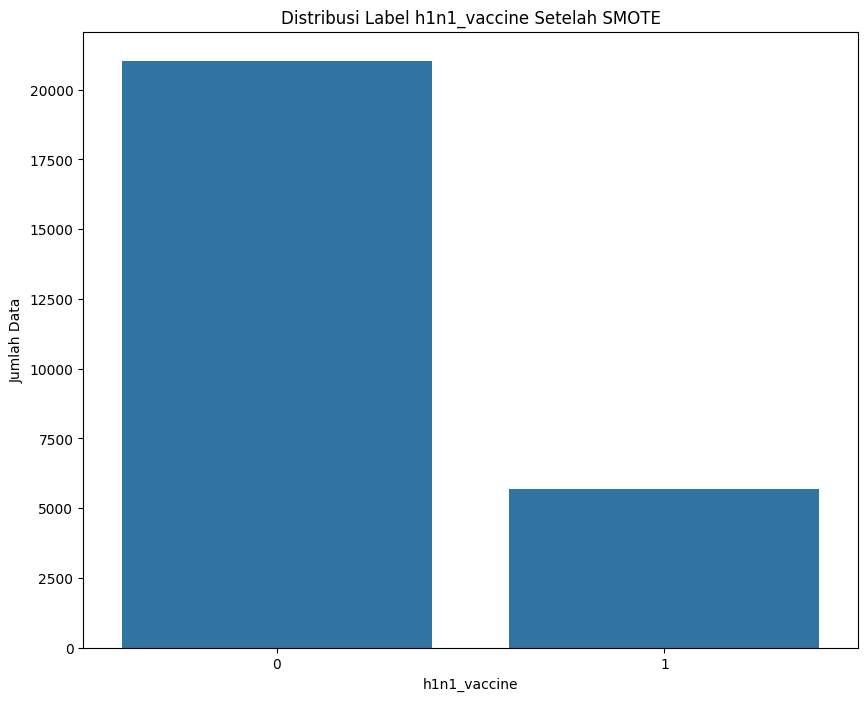

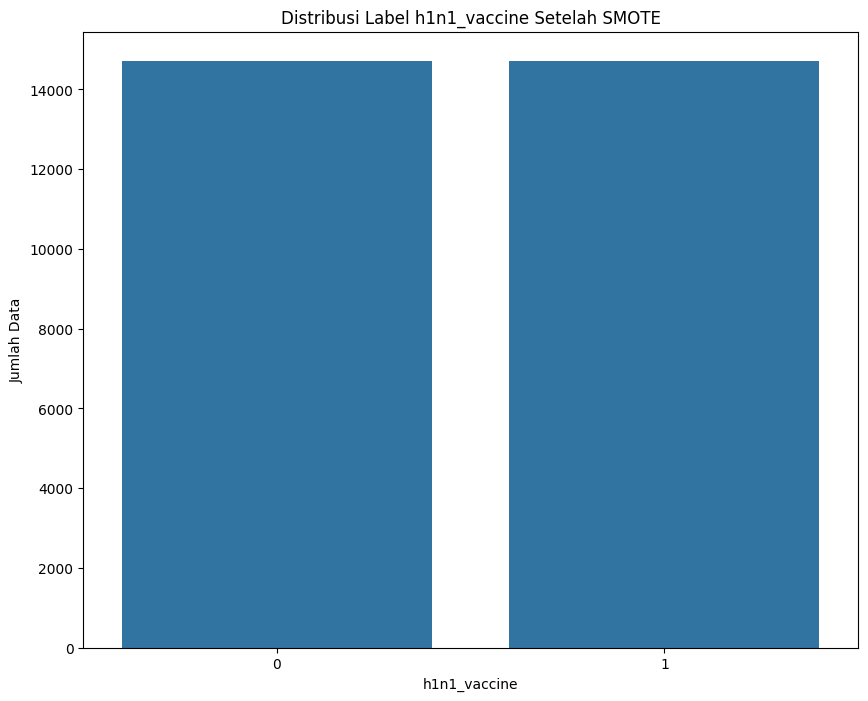

In [34]:
# tampilkan distribusi label
y = pd.DataFrame({
    'h1n1_vaccine': y
})

plt.figure(figsize=(10,8))
sns.countplot(x='h1n1_vaccine', data=y)
plt.title("Distribusi Label h1n1_vaccine Setelah SMOTE")
plt.xlabel("h1n1_vaccine")
plt.ylabel("Jumlah Data")
plt.show()

# tampilkan distribusi label
df_smote = pd.DataFrame({
    'h1n1_vaccine': y_smote
})

plt.figure(figsize=(10,8))
sns.countplot(x='h1n1_vaccine', data=df_smote)
plt.title("Distribusi Label h1n1_vaccine Setelah SMOTE")
plt.xlabel("h1n1_vaccine")
plt.ylabel("Jumlah Data")
plt.show()

<h1>Modeling</h1>

In [ ]:

# models = {
#     "SVM": (SVC(probability=True, random_state=42),
#         {
#             'C': [0.1, 1, 3, 10],
#             'gamma': ['scale', 0.01, 0.1],
#             'kernel': ['rbf']
#         }
#     ),
#     "Naive Bayes": (GaussianNB(),
#         {
#             'var_smoothing': [1e-9, 1e-8, 1e-7]
#         }
#     ),
#     "Random Forest": (RandomForestClassifier(random_state=42),
#         {
#             'n_estimators': [100, 150, 200, 300],
#             'max_depth': [None, 5, 10, 15],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4],
#             'max_features': ['sqrt', 'log2']
#         }
#     )
# }

# best_params = []
# best_models = {}
# for name, (model, param_grid) in models.items():
#     print(f"Tuning {name}...")
#     search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42)
#     search.fit(x_smote, y_smote)
#     best_models[name] = search.best_estimator_
#     best_params.append({
#         'Model': name,
#         'Best Parameters': search.best_params_,
#         'Best CV F1-Score': search.best_score_
#     })

# df_best_params = pd.DataFrame(best_params)

Tuning SVM...


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning Naive Bayes...


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=20. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning Random Forest...


,Model,Best Parameters,Best CV F1-Score
0,SVM,"{'kernel': 'rbf', 'gamma': 0.1, 'C': 10}",0.884959
1,Naive Bayes,{'var_smoothing': 1e-09},0.763800
2,Random Forest,"{'n_estimators': 150, 'min_samples_split': 5, ...",0.883870


In [ ]:
# for row in best_params:
#     print(f"\nModel: {row['Model']}")
#     print("Best Parameters:")
#     for param, value in row['Best Parameters'].items():
#         print(f"  {param}: {value}")
#     print(f"Best CV F1-Score: {row['Best CV F1-Score']:.4f}")



Model: SVM
Best Parameters:
  kernel: rbf
  gamma: 0.1
  C: 10
Best CV F1-Score: 0.8850

Model: Naive Bayes
Best Parameters:
  var_smoothing: 1e-09
Best CV F1-Score: 0.7638

Model: Random Forest
Best Parameters:
  n_estimators: 150
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: None
Best CV F1-Score: 0.8839


In [24]:
best_models = {"SVM": SVC(
        kernel='rbf',
        C=10,
        gamma=0.1,
        probability=True,
        random_state=42
    ),

    "Naive Bayes": GaussianNB(
        var_smoothing=1e-09
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42
    )
}


In [ ]:
evaluation_results = []
roc_curves = {}
conf_matrices = {}
result = {}

test_sizes = [0.1, 0.2, 0.3]


for ts in test_sizes:
    # panggil fungsi SETIAP test size
    x_smote, y_smote, x_test, y_test = split_and_smote(x, y, ts)
    
    for name, model in best_models.items():
        # Training di data SMOTE
        model.fit(x_smote, y_smote)

        # Testing di data asli
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]  
        result[name] = y_pred

        evaluation_results.append({
                'Test Size (%)': int(ts * 100),
                'Model': name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1-Score': f1_score(y_test, y_pred),
                'ROC AUC': roc_auc_score(y_test, y_prob)
            })

        conf_matrices[name] = confusion_matrix(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves[name] = (fpr, tpr)
    

In [37]:
df_eval = pd.DataFrame(evaluation_results)
df_eval

,Test Size (%),Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,10,SVM,0.828903,0.606178,0.553792,0.578802,0.815491
1,10,Naive Bayes,0.705354,0.396030,0.738977,0.515692,0.783646
2,10,Random Forest,0.851741,0.693878,0.539683,0.607143,0.869295
3,20,SVM,0.825534,0.599024,0.540969,0.568519,0.807739
4,20,Naive Bayes,0.702733,0.391679,0.721586,0.507750,0.772818
5,20,Random Forest,0.848933,0.681015,0.543612,0.604606,0.865111
6,30,SVM,0.824036,0.594072,0.541716,0.566687,0.812524
7,30,Naive Bayes,0.699988,0.388145,0.715629,0.503306,0.770462
8,30,Random Forest,0.846874,0.672476,0.544066,0.601494,0.865748


<h1>Evaluasi</h1>

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# smote = SMOTE(random_state=42)
# x_smote, y_smote = smote.fit_resample(x_train, y_train)

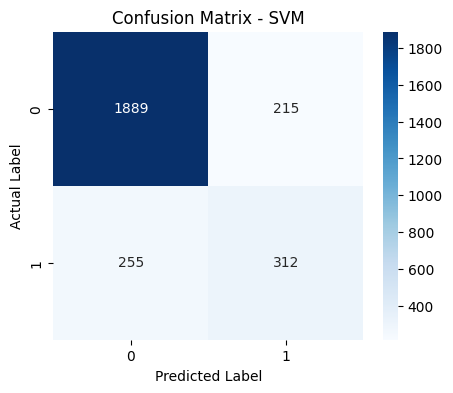


Classification Report - SVM
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2104
           1       0.59      0.55      0.57       567

    accuracy                           0.82      2671
   macro avg       0.74      0.72      0.73      2671
weighted avg       0.82      0.82      0.82      2671



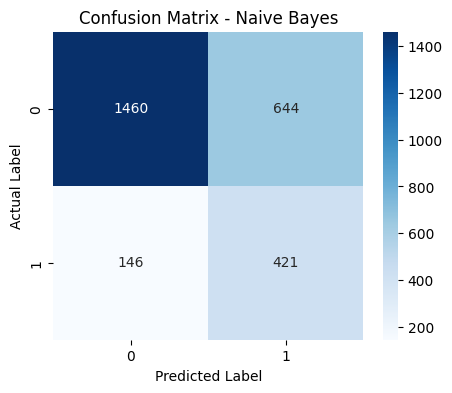


Classification Report - Naive Bayes
              precision    recall  f1-score   support

           0       0.91      0.69      0.79      2104
           1       0.40      0.74      0.52       567

    accuracy                           0.70      2671
   macro avg       0.65      0.72      0.65      2671
weighted avg       0.80      0.70      0.73      2671



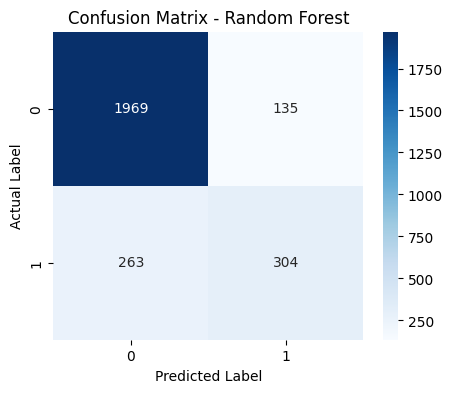


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2104
           1       0.69      0.54      0.60       567

    accuracy                           0.85      2671
   macro avg       0.79      0.74      0.76      2671
weighted avg       0.84      0.85      0.84      2671



In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

for name, model in best_models.items():
    model.fit(x_smote, y_smote)

    y_pred = model.predict(x_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

    # classification report
    print(f"\nClassification Report - {name}")
    print(classification_report(y_test, y_pred))



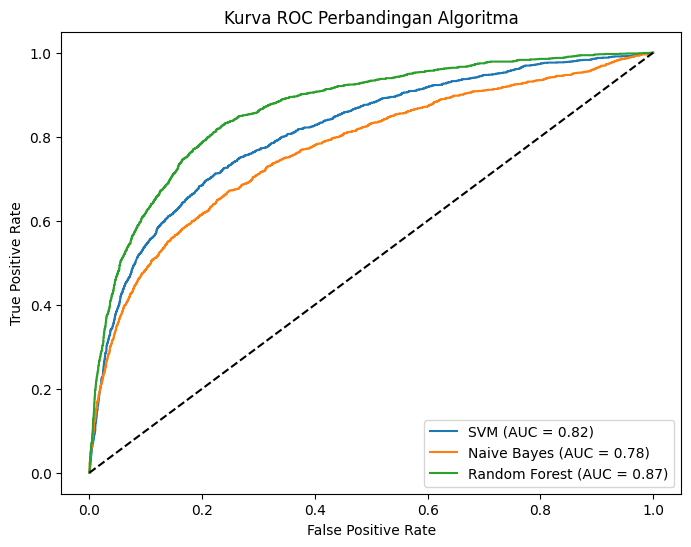

In [46]:
plt.figure(figsize=(8, 6))

for name, (fpr, tpr) in roc_curves.items():
    auc = df_eval[df_eval['Model'] == name]['ROC AUC'].values[0]
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC Perbandingan Algoritma')
plt.legend()
plt.show()


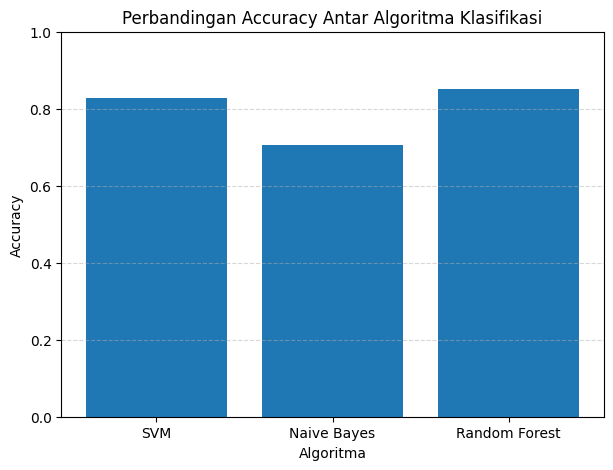

In [48]:
df_comparison = pd.DataFrame(evaluation_results)

plt.figure(figsize=(7, 5))
plt.bar(df_comparison['Model'], df_comparison['Accuracy'])
plt.xlabel('Algoritma')
plt.ylabel('Accuracy')
plt.title('Perbandingan Accuracy Antar Algoritma Klasifikasi')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [49]:
import pickle

# Menyimpan model terbaik (Random Forest)
with open('model_rf.pkl', 'wb') as f:
    pickle.dump(best_models['Random Forest'], f)

In [50]:
train_cols = x_train.columns.tolist()

# Simpan ke dalam file pkl
with open('training_columns.pkl', 'wb') as f:
    pickle.dump(train_cols, f)